In [1]:
from paretoKnapsackRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
#function to sample numItems from the dataset
def sample_dataset(simMatrix, item_ids, item_costs, numItems):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        numItems (int): Number of items to sample.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
        sampled_item_costs (list): List of sampled item costs of length numItems.
    '''
    sampled_indices = np.random.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    sampled_item_costs = [item_costs[i] for i in sampled_indices]

    return sampled_simMatrix, sampled_item_ids, sampled_item_costs

### Yelp - Average plotting across different random samples

In [3]:
def findApproximateParetoSolutions(simMatrix, item_ids, item_costs, sample_size, numSamples, maxBudget, dataset_name=None):
    '''
    Run algorithms over multiple random samples of the dataset, aggregate results, and plot mean +/- std.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.      
        item_costs (list): List of item costs of length N.
        sample_size (int): Number of items to sample from the dataset.
        numSamples (int): Number of random samples to run.
        maxBudget (float): Maximum budget for the knapsack problem.
        dataset_name (str | None): Optional dataset name for output file naming.
    '''
    # Cost grid (same for all samples)
    num_steps, min_cost = 15, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    # algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-1", "ParetoGreedy-2"]
    algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack", "TopK"]

    # containers across samples
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_costs_all = []
    pareto_points_counts = []

    print(f"Starting processing {numSamples} samples with sample size {sample_size} and max budget {maxBudget}")

    # iterate samples
    for sample_index in range(numSamples):
        print(f"Processing sample {sample_index + 1}/{numSamples}")
        
        # per-sample containers (will be appended to across budgets)
        sample_objectives = {alg: [] for alg in algo_names}
        sample_costs = {alg: [] for alg in algo_names}
        sample_runtimes = {alg: [] for alg in algo_names}

        # sample the dataset
        sampled_simMatrix, sampled_item_ids, sampled_item_costs = sample_dataset(simMatrix, item_ids, item_costs, sample_size)

        for budgetVal in cost_arr:
            # Initialize Pareto restaurants object
            paretoRest = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                   costs=sampled_item_costs,
                                                   simMatrix=sampled_simMatrix,
                                                   budget=budgetVal)

            # Plain Greedy
            plain_items, curr_objective, curr_cost, runTime = paretoRest.plainGreedy()
            sample_objectives['PlainGreedy'].append(curr_objective)
            sample_costs['PlainGreedy'].append(curr_cost)
            sample_runtimes['PlainGreedy'].append(runTime)

            # Two Guess Plain Greedy
            _, curr_objective, curr_cost, runTime = paretoRest.twoGuessPlainGreedy()
            sample_objectives['PlainGreedy-2Guess'].append(curr_objective)
            sample_costs['PlainGreedy-2Guess'].append(curr_cost)
            sample_runtimes['PlainGreedy-2Guess'].append(runTime)

            # One Guess Greedy Plus
            _, curr_objective, curr_cost, runTime = paretoRest.oneGuessGreedyPlus()
            sample_objectives['GreedyPlus-1Guess'].append(curr_objective)
            sample_costs['GreedyPlus-1Guess'].append(curr_cost)
            sample_runtimes['GreedyPlus-1Guess'].append(runTime)

            # Top-k (use #items chosen by PlainGreedy)
            k_val = max(1, len(plain_items))
            _, curr_objective, curr_cost, runTime = paretoRest.top_k(k_val)
            sample_objectives['TopK'].append(curr_objective)
            sample_costs['TopK'].append(curr_cost)
            sample_runtimes['TopK'].append(runTime)

        # Pareto Greedy (computed once per sample at full budget)
        print(f"  Running ParetoGreedy algorithms for sample {sample_index + 1}")
        paretoRest_full = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                    costs=sampled_item_costs,
                                                    simMatrix=sampled_simMatrix,
                                                    budget=maxBudget)
        pg1_costs, pg1_objectives, _, pg1_time = paretoRest_full.prefixParetoGreedy_1Guess()
        # pg2_costs, pg2_objectives, _, pg2_time = paretoRest_full.prefixParetoGreedy_2Guess()

        # Ensure pareto objectives align with the cost_arr length if possible.
        # We'll resample/pad to cost_arr length: simplest is to interpolate by cost.
        def align_to_cost_arr(costs, objs):
            if len(costs) == 0:
                return np.zeros_like(cost_arr, dtype=float)
            costs = np.array(costs)
            objs = np.array(objs)
            # if cost objective mapping is strictly increasing in costs, we can interpolate
            return np.interp(cost_arr, costs, objs, left=objs[0], right=objs[-1])

        sample_objectives['ParetoGreedy-Knapsack'] = list(align_to_cost_arr(pg1_costs, pg1_objectives))
        # sample_objectives['ParetoGreedy-2'] = list(align_to_cost_arr(pg2_costs, pg2_objectives))
        sample_runtimes['ParetoGreedy-Knapsack'].append(pg1_time)
        # sample_runtimes['ParetoGreedy-2'].append(pg2_time)
        pareto_costs_all.extend(pg1_costs)
        pareto_points_counts.append(len(pg1_costs))

        # convert per-sample lists to numpy arrays and store in all_objectives
        for alg in algo_names:
            arr = np.array(sample_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_objectives[alg].append(arr)
            # store total runtime per sample (sum over budgets or single value for pareto)
            runtimes = sample_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

        print(f"Completed sample {sample_index + 1}")

    print("All samples processed, computing statistics and plotting")

    # compute mean and std across samples for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (numSamples, len(cost_arr))
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0) * 0.5

    mean_pareto_points = int(np.round(np.mean(pareto_points_counts))) if len(pareto_points_counts) > 0 else 0
    if mean_pareto_points < 1:
        mean_pareto_points = 1

    # Plot mean objective with shaded std band (consistent with teams plotting)
    # colors = cm.viridis(np.linspace(0.05, 0.85, len(algo_names)))
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3,1,1,1))]
    markers = ['o', 's', '^', 'v', 'D']

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    pareto_legend_handle = None
    rng = np.random.default_rng()
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg in {"ParetoGreedy-Knapsack", "ParetoGreedy-2"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'

        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-2":
            marker = "x"
            zorder = 5
        elif alg == "ParetoGreedy-Knapsack":
            marker = "D"
            zorder = 4

        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        label_map[alg] = label
        if is_pareto:
            ax.plot(cost_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            pareto_costs_unique = np.unique(np.array(pareto_costs_all, dtype=float))
            pareto_costs_unique = pareto_costs_unique[(pareto_costs_unique >= cost_arr.min()) & (pareto_costs_unique <= cost_arr.max())]
            if pareto_costs_unique.size > 0:
                keep_count = max(1, int(np.ceil(pareto_costs_unique.size * 0.75)))
                keep_idx = rng.choice(pareto_costs_unique.size, size=keep_count, replace=False)
                pareto_costs_unique = np.sort(pareto_costs_unique[keep_idx])
                min_sep = 0.5 * (cost_arr[1] - cost_arr[0]) if cost_arr.size > 1 else 0
                filtered_costs = [pareto_costs_unique[0]]
                for c in pareto_costs_unique[1:]:
                    if c - filtered_costs[-1] >= min_sep:
                        filtered_costs.append(c)
                pareto_costs_unique = np.array(filtered_costs, dtype=float)
            pareto_mean_vals = np.interp(pareto_costs_unique, cost_arr, mean)
            ax.scatter(pareto_costs_unique, pareto_mean_vals,
                       label="_nolegend_",
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
            if alg == "ParetoGreedy-Knapsack":
                from matplotlib.lines import Line2D
                pareto_legend_handle = Line2D([0], [0],
                                              color=color,
                                              linestyle=line_style,
                                              marker=marker,
                                              markersize=marker_size,
                                              markeredgewidth=1.1,
                                              markeredgecolor='k',
                                              linewidth=1.8)
        else:
            ax.plot(cost_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=1.1,
                    markeredgecolor='k',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Cost ($c_\ell$)', fontsize=28)
    ax.set_ylabel(r'Mean objective value ($\bar{f}$)', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Legend (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        handle_map = dict(zip(labels, handles))
        pareto_label = label_map.get("ParetoGreedy-Knapsack")
        if pareto_label and pareto_legend_handle is not None:
            handle_map[pareto_label] = pareto_legend_handle
        ordered_labels = []
        if pareto_label:
            ordered_labels.append(pareto_label)
        ordered_labels.extend([label_map[alg] for alg in algo_names if alg != "ParetoGreedy-Knapsack"])
        ordered_handles = [handle_map[l] for l in ordered_labels if l in handle_map]

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    # Save legend as separate PDF (only once)
    if handles:
        legend_out_path = plots_dir / "knapsack_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(ordered_handles, ordered_labels, loc='center', ncol=3, fontsize=20, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)

    plt.show()

    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    print("\n".join(runtime_lines))

### Yelp Phoenix Experiments

In [4]:
#Import Yelp dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    phoenix_costs = pickle.load(fp)


2026-01-31 16:42:11,291 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:42:11,297 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:42:11,328 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-01-31 16:42:11,458 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5


Starting processing 5 samples with sample size 50 and max budget 50
Processing sample 1/5


2026-01-31 16:42:11,844 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-01-31 16:42:12,814 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:42:14,449 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:42:17,003 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:42:20,698 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:42:25,615 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:42:31,955 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:42:40,013 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-01-31 16:42:49,617 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 1


2026-01-31 16:43:27,969 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:43:27,975 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:43:28,013 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-01-31 16:43:28,142 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5


Completed sample 1
Processing sample 2/5


2026-01-31 16:43:28,494 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-01-31 16:43:29,245 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:43:30,515 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:43:32,427 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:43:35,160 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:43:38,800 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:43:43,728 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:43:49,885 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-01-31 16:43:57,471 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 2


2026-01-31 16:44:29,285 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:44:29,293 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:44:29,344 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0


Completed sample 2
Processing sample 3/5


2026-01-31 16:44:29,539 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5
2026-01-31 16:44:30,078 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-01-31 16:44:31,102 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:44:32,846 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:44:35,463 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:44:39,090 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:44:44,173 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:44:50,760 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:44:58,788 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 3


2026-01-31 16:45:46,749 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:45:46,755 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:45:46,864 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0


Completed sample 3
Processing sample 4/5


2026-01-31 16:45:47,201 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5
2026-01-31 16:45:48,100 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-01-31 16:45:49,818 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:45:52,628 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:45:56,864 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:46:02,427 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:46:09,771 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:46:18,993 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:46:30,256 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 4


2026-01-31 16:47:35,178 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:47:35,180 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:47:35,246 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0


Completed sample 4
Processing sample 5/5


2026-01-31 16:47:35,432 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5
2026-01-31 16:47:36,005 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-01-31 16:47:37,057 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:47:38,845 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:47:41,705 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:47:45,743 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:47:51,275 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:47:58,526 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:48:07,627 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 5
Completed sample 5
All samples processed, computing statistics and plotting


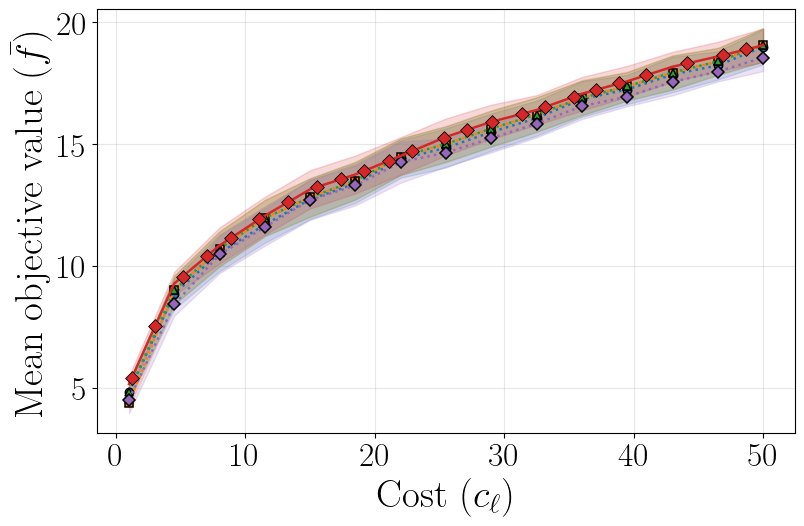

Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.192 ± 0.029
  - PlainGreedy-2Guess: 57.749 ± 11.543
  - GreedyPlus-1Guess: 23.656 ± 3.913
  - ParetoGreedy-Knapsack: 0.627 ± 0.106
  - TopK: 0.006 ± 0.000


In [5]:
# Call findApproximateParetoSolutions (adjust parameters as needed)
sample_size = 50
numSamples = 5  # e.g., number of random samples
maxBudget = 50

findApproximateParetoSolutions(phoenix_simMatrix, phoenix_ids, phoenix_costs, sample_size, numSamples, maxBudget, dataset_name="Yelp-PHX")

### Yelp Vegas Experiments

In [6]:
#Import Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_' 

#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    vegas_costs = pickle.load(fp)

2026-01-31 16:49:03,611 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:49:03,614 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:49:03,618 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-01-31 16:49:03,628 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5
2026-01-31 16:49:03,677 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0


Starting processing 5 samples with sample size 50 and max budget 50
Processing sample 1/5


2026-01-31 16:49:03,865 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:49:04,435 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:49:05,610 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:49:07,679 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:49:10,952 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:49:15,573 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:49:21,542 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-01-31 16:49:28,952 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=43.0
2026-01-31 16:49:37,411 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 1


2026-01-31 16:49:58,028 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:49:58,030 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:49:58,033 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-01-31 16:49:58,043 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5
2026-01-31 16:49:58,085 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0


Completed sample 1
Processing sample 2/5


2026-01-31 16:49:58,256 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:49:58,890 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:50:00,294 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:50:03,090 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:50:07,182 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:50:12,773 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:50:19,631 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-01-31 16:50:27,650 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=43.0
2026-01-31 16:50:36,614 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 2


2026-01-31 16:50:57,901 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:50:57,903 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:50:57,915 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-01-31 16:50:57,953 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5
2026-01-31 16:50:58,088 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0


Completed sample 2
Processing sample 3/5


2026-01-31 16:50:58,426 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:50:59,270 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:51:00,837 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:51:03,467 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:51:07,423 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:51:12,877 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:51:19,992 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-01-31 16:51:28,645 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=43.0
2026-01-31 16:51:38,701 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 3


2026-01-31 16:52:02,786 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:52:02,790 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:52:02,797 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-01-31 16:52:02,847 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5


Completed sample 3
Processing sample 4/5


2026-01-31 16:52:02,997 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-01-31 16:52:03,486 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:52:04,613 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:52:06,680 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:52:10,053 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:52:15,139 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:52:21,701 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:52:30,098 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-01-31 16:52:39,833 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 4


2026-01-31 16:53:17,593 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-31 16:53:17,594 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-01-31 16:53:17,599 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-01-31 16:53:17,614 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5
2026-01-31 16:53:17,688 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0


Completed sample 4
Processing sample 5/5


2026-01-31 16:53:17,941 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-01-31 16:53:18,657 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-01-31 16:53:20,122 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-01-31 16:53:22,698 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-01-31 16:53:26,637 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-01-31 16:53:32,077 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-01-31 16:53:38,893 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-01-31 16:53:47,108 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=43.0
2026-01-31 16:53:56,559 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running ParetoGreedy algorithms for sample 5
Completed sample 5
All samples processed, computing statistics and plotting


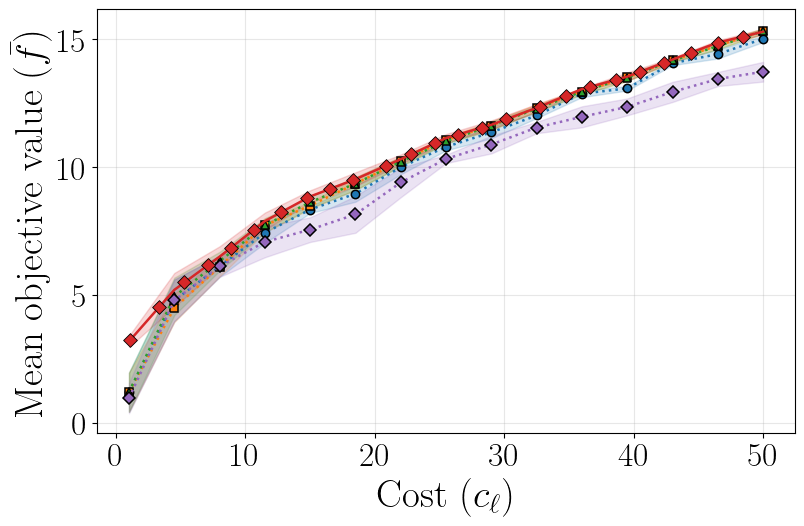

Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.147 ± 0.019
  - PlainGreedy-2Guess: 49.421 ± 4.615
  - GreedyPlus-1Guess: 13.064 ± 2.569
  - ParetoGreedy-Knapsack: 0.488 ± 0.050
  - TopK: 0.005 ± 0.000


In [7]:
# Call findApproximateParetoSolutions (adjust parameters as needed)
sample_size = 50
numSamples = 5  # e.g., number of random samples
maxBudget = 50

findApproximateParetoSolutions(vegas_simMatrix, vegas_ids, vegas_costs, sample_size, numSamples, maxBudget, dataset_name="Yelp-LV")